In [87]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import openpnm as op
import networkx

Demonstration of solving a simple network

# Packing Visualisation
A very simple packing to demonstrait the concept

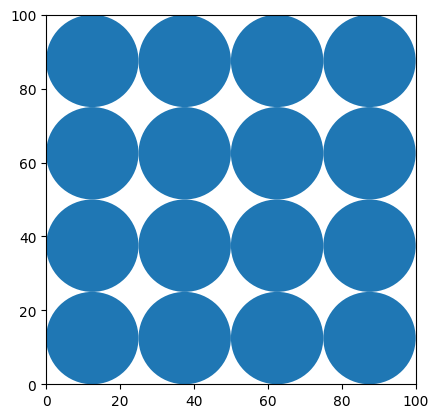

In [100]:
radius = 50/4
domain_width = 100
domain_height = 100

fig, ax = plt.subplots()
xi = []
for i in np.arange(0, domain_width, radius*2):
    for j in np.arange(0, domain_height, radius*2):
        xi.append((i+radius,j+radius))
        c = patches.Circle((i+radius,j+radius), radius)
        ax.add_patch(c)

ax.set_xlim(0,domain_width)
ax.set_ylim(0,domain_height)
ax.set_aspect('equal')

nx = int(domain_width/(2*radius))
ny = int(domain_height/(2*radius))

# Network Representation

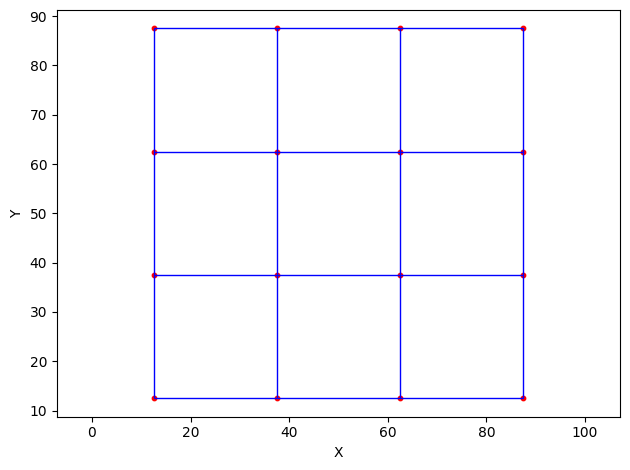

In [101]:
pn = op.network.Cubic(shape=[nx, ny], spacing=2*radius)
ax = op.visualization.plot_coordinates(pn)
ax = op.visualization.plot_connections(pn, ax=ax)

From the network create a oriented incident matrix. Since the original graph is not directed this is not unique.

True


/tmp/ipykernel_2487098/3463363868.py:9: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = networkx.incidence_matrix(op.io.network_to_networkx(pn), oriented=True).todense().T


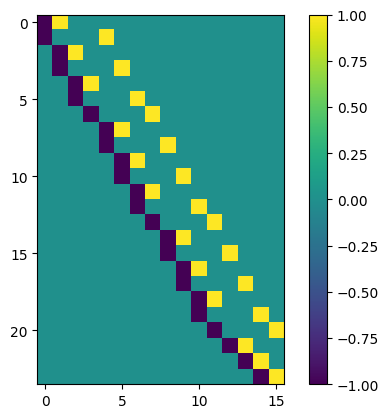

In [122]:
tree = scipy.spatial.KDTree(xi)
pairs = sorted(list(tree.query_pairs(r=2*radius, eps=1e-3)), key = lambda tup: (tup[0], tup[1]))

g1 = op.io.network_to_networkx(pn)
g2 =networkx.from_edgelist(pairs)

print(networkx.is_isomorphic(g1, g2))

A = networkx.incidence_matrix(op.io.network_to_networkx(pn), oriented=True).todense().T
plt.imshow(A)
plt.colorbar()

/tmp/ipykernel_2487098/434032233.py:1: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_broken = networkx.incidence_matrix(networkx.from_edgelist(pairs), oriented=True, edgelist=pairs, nodelist=sorted(g2.nodes())).todense().T


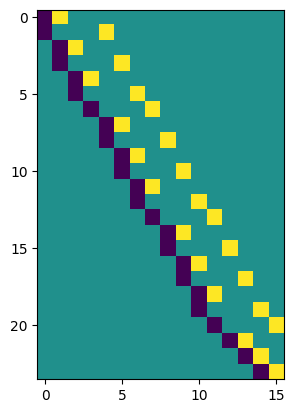

[(0, 1), (0, 4), (1, 2), (1, 5), (2, 3), (2, 6), (3, 7), (4, 5), (4, 8), (5, 6), (5, 9), (6, 7), (6, 10), (7, 11), (8, 9), (8, 12), (9, 10), (9, 13), (10, 11), (10, 14), (11, 15), (12, 13), (13, 14), (14, 15)]
[0, 1, 4, 2, 5, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[(0, 1), (0, 4), (1, 2), (1, 5), (2, 3), (2, 6), (3, 7), (4, 5), (4, 8), (5, 6), (5, 9), (6, 7), (6, 10), (7, 11), (8, 9), (8, 12), (9, 10), (9, 13), (10, 11), (10, 14), (11, 15), (12, 13), (13, 14), (14, 15)]


In [135]:
A_broken = networkx.incidence_matrix(networkx.from_edgelist(pairs), oriented=True, edgelist=pairs, nodelist=sorted(g2.nodes())).todense().T
plt.imshow(A_broken)
plt.show()
print(g1.edges())
print(g2.nodes())
print(pairs)

If there are $n$ nodes and $m$ edges, the rank should be the $n-1$ as the graph is connected:

In [124]:
m, n = A.shape
print(A.shape)
np.linalg.matrix_rank(A)

(24, 16)


15

To solve this we "ground" one node by removing a column to produce independant columns in A then, $A^TA$ is invertable, positive definite.

In [125]:
np.linalg.matrix_rank(A[:,:-1]) # make a full rank by grounding a columnn

15

For $m$ currents and $n-1$ voltages, we need $m+n-1$ equations. We have Fourier's law on $m$ edges and Kirchhoff's Law at $n-1$ nodes.

"KCL" is the left nullspace: $A^T\mathbf{y}=0$ but with external sources of flux this is $A^T\mathbf{y}=\mathbf{b}$

Newtons law of cooling: $\mathbf{y} = KA\mathbf{x}$

Combining gives:

$A^TKA\mathbf{x} = \mathbf{b}$

K: conductivity matrix (diagonal)

$\mathbf{x}$: the node temperatures

$\mathbf{y}$: edge flux

$\mathbf{v}$: source temperatures

$\mathbf{b}$: current source

In [126]:
# use the same conductivity for time being
K = np.eye(m,m) #* np.random.rand(m,1)

In [127]:
# heat source in the top left
b = np.zeros((n, 1))
b[0:4] = 1

In [128]:
np.linalg.matrix_rank(A.T @ K @ A) # we still need to ground a node

15

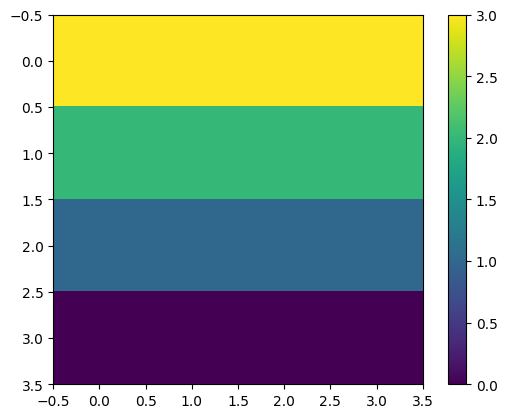

In [129]:
A_grounded = A[:,:-4]
x = np.linalg.solve((A_grounded.T @ A_grounded), b[:-4]) # ground the bottom right node at 0
x = np.append(x, [0, 0 ,0, 0])
X = np.reshape(x, (nx,ny))
plt.imshow(X)
plt.colorbar()

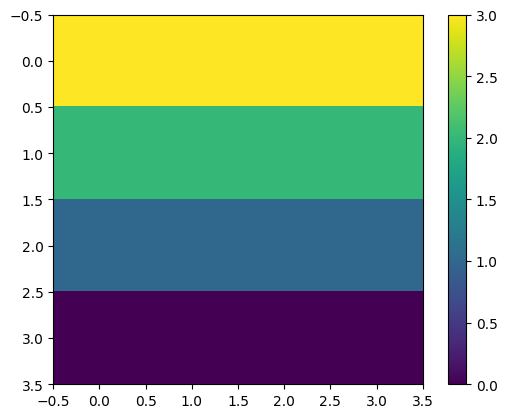

In [136]:
A_grounded = A_broken[:,:-4]
x = np.linalg.solve((A_grounded.T @ A_grounded), b[:-4]) # ground the bottom right node at 0
x = np.append(x, [0, 0 ,0,0])
X = np.reshape(x, (nx,ny))
plt.imshow(X)
plt.colorbar()

As expected we get a linear gradient as all the contact resisances are the same.